# Crewling





In [30]:
#crewling
import requests
import time
from tqdm import tqdm

base_url = 'https://www.ad.co.il/car?pageindex='
all_count = 400
response_data = []

for i in tqdm(range(all_count)):
    for my_count in range(1, all_count + 1):
        url = base_url + str(my_count)
        response = requests.get(url)
        response_data.append(response.content)


time.sleep(0.2)  # Delay 0.2 seconds between requests


100%|██████████| 400/400 [8:35:58<00:00, 77.40s/it]  


# Scraping


In [31]:
#scraping
from bs4 import BeautifulSoup
import pandas as pd

data = []

for content in response_data:
    soup = BeautifulSoup(content, 'html.parser')
    feed_items = soup.find_all('div', {'class': 'card-block'})

    for item in feed_items:
        km_element = item.find('span', {'class': 'ms-1'})
        km_value = km_element.get_text(strip=True) if km_element else None

        year_element = item.find('p', {'class': 'card-text'})
        year_value = year_element.get_text(strip=True) if year_element else None

        price_element = item.find('div', {'class': 'price ms-1'})
        price_value = price_element.get_text(strip=True) if price_element else None

        hand_element = item.find('div', {'class': 'flex-fill card-icon-wrapper'})
        hand_value = hand_element.get_text(strip=True) if hand_element else None

        name_element = item.find('h2', {'class': 'card-title mb-0 mb-sm-1'})
        name_value = name_element.get_text(strip=True) if name_element else None


        data.append({"Hand": hand_value, "KM": km_value, "Year": year_value, "Company": name_value, "Price": price_value})


df = pd.DataFrame(columns=['Hand', 'Year', 'Company', 'Price','KM'], data=data)
df.to_csv('raw_data.csv', index=False)
df

,Hand,Year,Company,Price,KM
0,3יד,2011,פולקסווגן גולף פלוס,"18,500 ₪","187Kק""מ"
1,1יד,2018,וולוו S60,"200,005 ₪","54Kק""מ"
2,2יד,2020,קיה נירו,128 ₪,"46Kק""מ"
3,2יד,None,אאודי A3,"130,000 ₪","81Kק""מ"
4,2יד,2011,יונדאי אקסנט,"17,500 ₪","155Kק""מ"
...,...,...,...,...,...
8159524,1יד,None,סוזוקי סלריו,"43,000 ₪","71Kק""מ"
8159525,5יד,None,פולקסווגן שירוקו,"29,999 ₪","180Kק""מ"
8159526,None,2014,None,None,None
8159527,None,2015,None,None,None


# Data Cleaning


In [41]:
# Data cleaning
import pandas as pd

with open('raw_data.csv', 'r') as file:
    df = pd.read_csv(file)

    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    df = df[df['KM'].str.contains('K')] #if value without K clean it
    for index, row in df.iterrows():
        df.at[index, 'Hand'] = df.at[index, 'Hand'].replace('יד', '').strip()
        df.at[index, 'Price'] = int(''.join(filter(str.isdigit, df.at[index, 'Price']))) #change from str to int
        df.at[index, 'KM']= df.at[index, 'KM'].replace('K','000').strip()
        df.at[index, 'KM'] = int(df.at[index, 'KM'].replace('ק"מ', '').strip())

    df = df[df['Price'] >= 1000]#save all the prices bigger then 1000
    df.reset_index(drop=True, inplace=True)
    df.to_csv('clean_data.csv', index=False)
    df

# EDA + Visualization





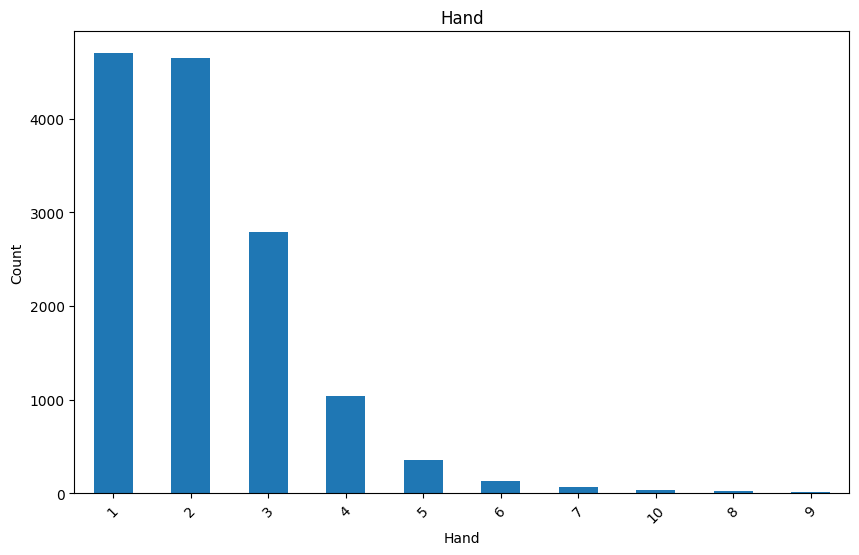

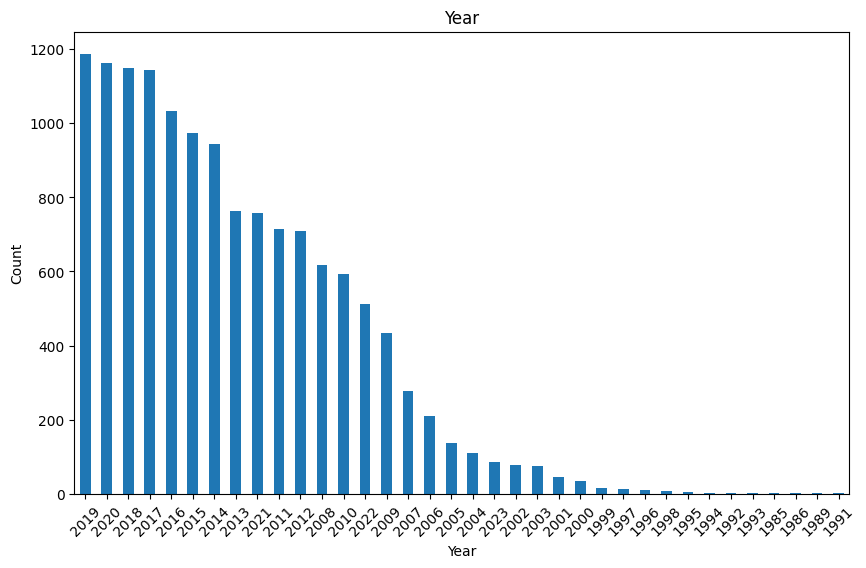

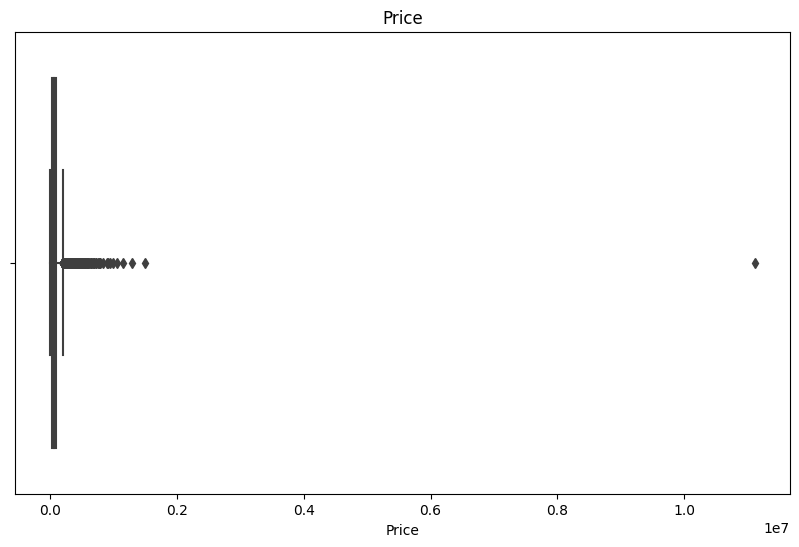

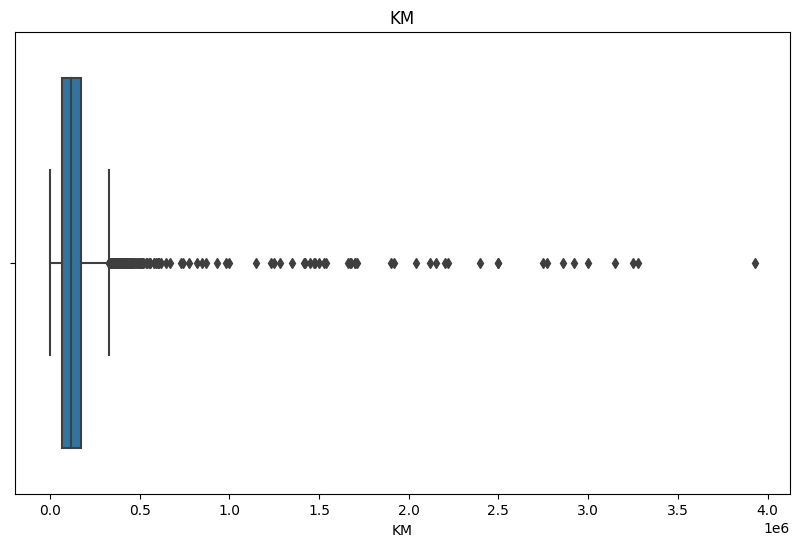

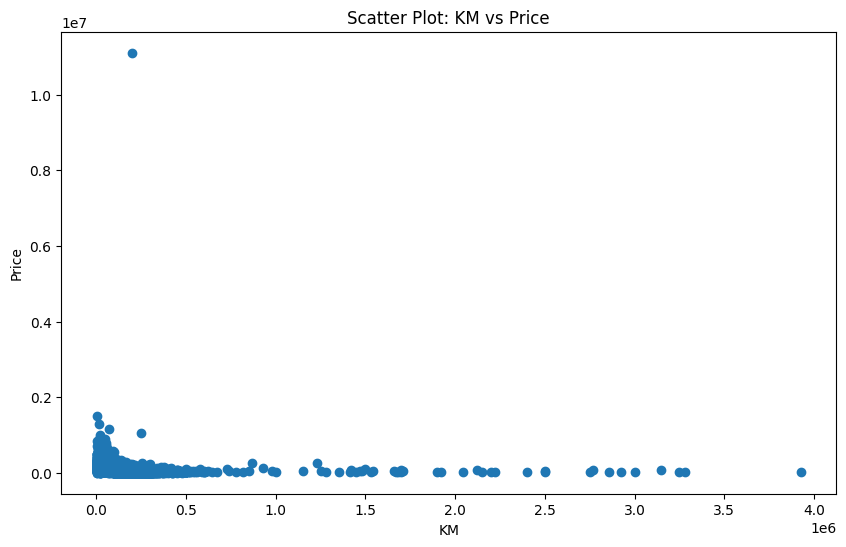

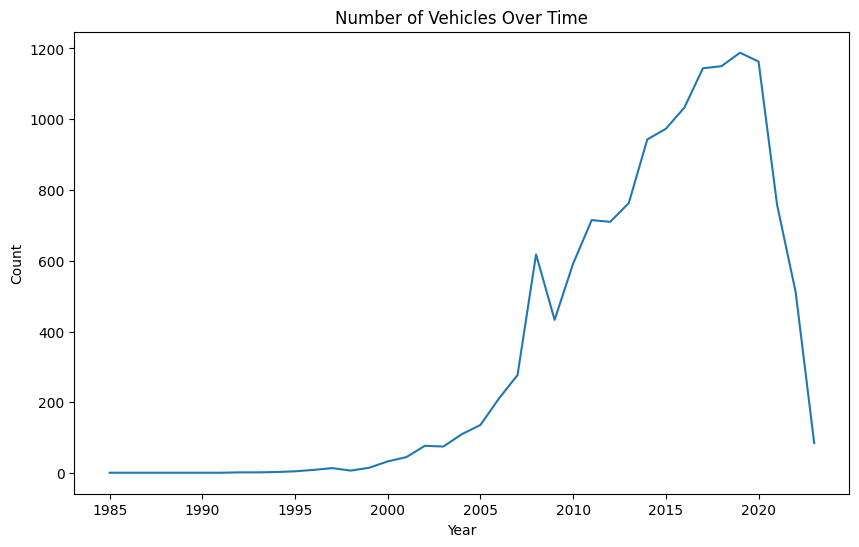

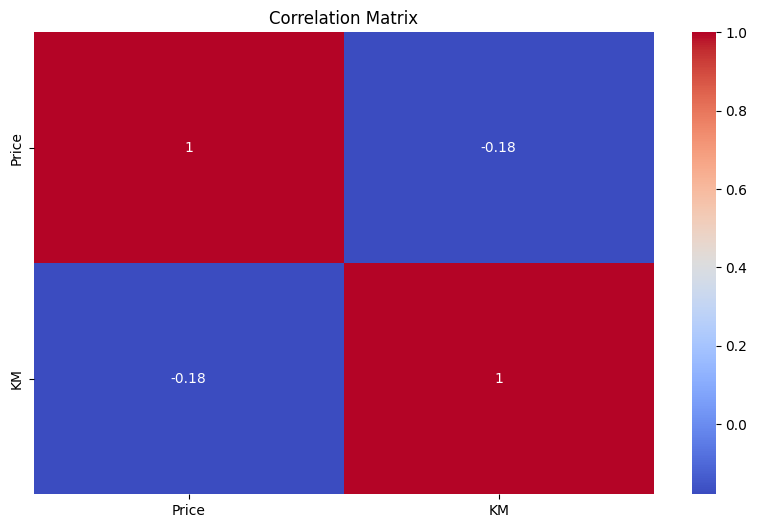

In [43]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
#histograma between hand and price when hand increase price decrease
numeric_cols = ['Price', 'KM']
categorical_cols = ['Hand', 'Year']


with open('clean_data.csv', 'r') as file:
    df = pd.read_csv(file, header=0, sep=',')

    # # Histograms
    # df[numeric_cols].hist(bins=10, figsize=(10, 6))
    # plt.tight_layout()
    # plt.show()

    # Bar plots
    for col in categorical_cols:
        plt.figure(figsize=(10, 6))
        df[col].value_counts().plot(kind='bar')
        plt.title(col)
        # plt.xlabel('Categories')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

    # Box plots
    for col in numeric_cols:
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df, x=col)
        plt.title(col)
        plt.xlabel(col)
        plt.show()

    # Scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df['KM'], df['Price'])
    plt.title('Scatter Plot: KM vs Price')
    plt.xlabel('KM')
    plt.ylabel('Price')
    plt.show()

    # Time series analysis
    df['Year'] = pd.to_datetime(df['Year'], format='%Y')
    df_yearly = df.groupby(df['Year'].dt.year).size()
    plt.figure(figsize=(10, 6))
    df_yearly.plot(kind='line')
    plt.title('Number of Vehicles Over Time')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.show()

    # Correlation matrix and heatmap
    correlation_matrix = df[numeric_cols].corr()
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

